In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *

#used for GUI
%matplotlib notebook

#find transform
import transforms3d as t3d
import time

# collect MSE from all the Trials
E_list = []

## Motor Functions

### zero on the center, user enter the startng postion in degree

In [2]:
c = moteus.Controller()

## Setup the Motor

#### Run the code below to check the motor each Test

In [ ]:
n = input('Enter the number of loop')
await stopping_acc_test(c,int(n))

## Let's Start the Test

### First, zero the motor and save the initial position(radian,shows in degree)

In [ ]:
input('Press Enter to Start the Test')
ip = await motor_home(c,stop_torque=.1,v=1)
print("Initial Starting Radian: ", ip*(2*math.pi))

In [ ]:
ip = await read_p()

### Run the CT scan for checking the postion error later.

### Once get the intial starting postion, run the testing function with the desired postion, and then run the CT scanner once motor moved.

In [ ]:
data_p_list = []
data_degree_list = []
data_time_list = []

In [ ]:
uds = int(input('Enter the desired degree (2000)'))
data_degree_list.append(uds)

In [ ]:
currcent_p_list = []
currcent_p_list.append(await one_axis_farward(c,intial_position =ip,user_degree=uds))
data_p_list.append(currcent_p_list)
data_time_list.append(time.time())

In [ ]:
currcent_p_list = []
currcent_p_list.append(await one_axis_backward(c,intial_position =ip,user_degree=uds))
data_p_list.append(currcent_p_list)
data_time_list.append(time.time())

### Plot the result

In [ ]:
import pickle
with open('position.pkl', 'wb') as f:
    pickle.dump(data_p_list, f)
with open('degree.pkl', 'wb') as f:
    pickle.dump(data_degree_list, f)
with open('time.pkl', 'wb') as f:
    pickle.dump(data_time_list, f)

#### python -m moteus_gui.tview --devices=1

## Feltch the DICOM file from server

### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient

### Selected Series on the top tabs

### On the left hand side input: DIMITRI07041995 as the Patient ID

### In the middle section select Newest Frist in the Order by Tab

### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit

### Download the 1st row by clicking the 3 dots symbol and downolad it

### Once Downloaded, extract the DICOM files ONLY to the following folder: ./test_data/DICOM

## Processing DICOM file

In [3]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load  

### Select the desired DICOM file

In [4]:
data_directory = "./test_data/DICOM"
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()         
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.131772622000496481…

### Convert DICOM files

In [7]:
#convert scan to mesh for finding markers via thresholding
scan_file = series_file_names[selected_series]
convert_scan_to_mha(scan_file)

### Disaply DICOM file (Left and Right are the SAME)

origin: (-179.043, -176.5, -352.812)
size: (512, 512, 283)
spacing: (0.689453, 0.689453, 1.25)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1

origin: (-179.043, -176.5, -352.812)
size: (512, 512, 283)
spacing: (0.689453, 0.689453, 1.25)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1



<IPython.core.display.Javascript object>


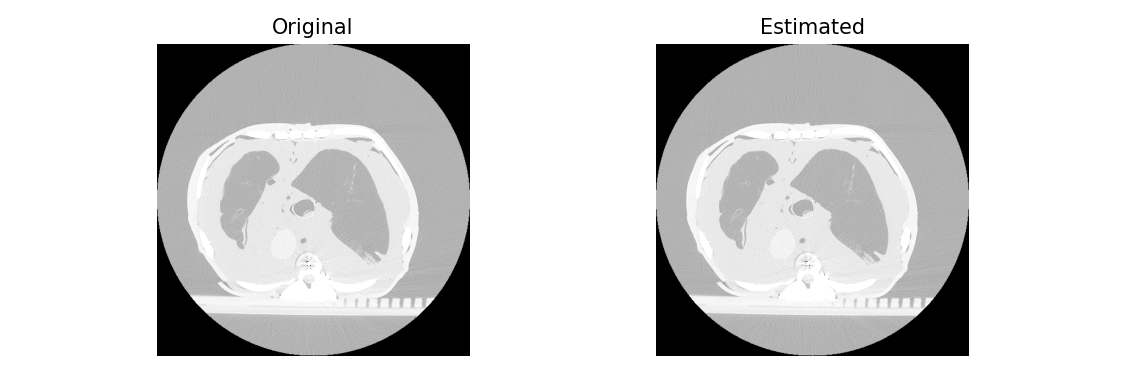

In [9]:
display_Dicom("temp_mesh.mha","temp_mesh.mha")

### Once the Imag above looks right, run the following code the find the neede error and transform

### Pick target marker postion(1 or 2)

In [8]:
#choose target marker
name = input('Enter the targert marker postion, please enter 1 or 2: ')
if int(name) == 1:
    target_marker = 'marker1'
elif int(name) == 2:
    target_marker = 'marker2'
print("You have choose the target marker: ",target_marker)

Enter the targert marker postion, please enter 1 or 2: 2
You have choose the target marker:  marker2


In [11]:
#find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
marker, marker_centroid_coordinates, pcd_selected, mesh, coordinate_frame, good_centroid_clusters = find_candidate_centroids(marker = target_marker)

#display candidate fiducials
o3d.visualization.draw_geometries([pcd_selected, mesh])
print('marker centroid coordinates from design: {}'.format(marker))
print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

#find best transform and marker from candidate fiducials
final_R, final_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 21


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]C:\Users\derek\ECE\CT Research\ct-fiducial-tracking-main\ct_tracking_library\ct_tracking_functions.py:405: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residules, rank, singval = np.linalg.lstsq(A,f)
100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 130.01it/s]


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[ 0  3  6 10]
[ 1  2  4  5  7  8  9 11]


AttributeError: 'str' object has no attribute 'shape'

In [ ]:
#display tracked  markers and coordinate frames
marker = np.load('./test_data/'+target_marker+'.npy')
marker_3d_base, marker_3d_transformed, err = visualize_tracked_marker(marker, final_R, final_t, permuted_centroids)
o3d.visualization.draw_geometries(marker_3d_base+marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print(err)
print("ERROR: ",np.linalg.norm(err))

#visualize everything at once
visualization_list = [pcd_selected, mesh]+marker_3d_base+marker_3d_transformed
o3d.visualization.draw_geometries(visualization_list)

In [ ]:
E_list.append(np.linalg.norm(err))

## Once Finished ALL 5 trials, plot the err

In [ ]:
plt.plot(E_list)

In [ ]:
from transforms3d.euler import euler2mat, mat2euler

In [ ]:
def find_Tbee(Tsbb,Tsbee):
    """
    Tsbb^-1 * Tsbee
    """
    return False

In [ ]:
def find_all_error(T1,T2):
    """
    output (x,y,z)+RMSE
    """
    assert T1.shape == (2, 2)
    assert T2.shape == (2, 2)
    deta_T = T1@Hinv(T2)
    print(deta_T)
    R,p_error = T2t(deta_T)
    o_r = t3d.euler.euler2mat(R)
    return p_error,o_r

### Helper function

In [ ]:
def Hinv(T):
    assert T.shape == (2, 2)
    r,d = T2t(T)
    T_1 = t2T(np.linalg.inv(r),-np.linalg.inv(r)@d)
    return T_1

In [ ]:
def t2T(r,t):
    assert isinstance(r,np.ndarray)
    assert isinstance(t,np.ndarray)
    """
    This function that takes R and t to a homogeneous tansfamred matrix:

    Args: r(numpy.ndarray): rotation matrix
          t(numpy.ndarray): translation vector

    Returns: 4x4 matrix

    """
    return np.array([[r, t], [np.zeros((1,3)), 1]])

In [ ]:
def T2t(T):
    assert T.shape == (2, 2)
    return T[0,0],T[0,1]

In [ ]:
Ta = t2T(final_R,final_t)
Tb = t2T(final_R,final_t)

In [ ]:
deta_T = Ta@Hinv(Tb)
r,d = T2t(Tb)
c = -np.linalg.inv(r)@d
print(c.shape)
#print(deta_T)
#print(deta_T[0,1])
#print(deta_T[0,1].shape)

In [ ]:
R,p = T2t(deta_T)
print(R)
print(p)

# A)
## with the motor not moved, scan it ONCE and find:
### T^(sb)_b and T^(sb)_ee
### T^(b)_ee = (T^(sb)_b)^-1*T^(sb)_ee

# B)
## with the motor not moved, scan it AGAIN and find:
### 1T^(sb)_b and 1T^(sb)_ee
### 1T^(b)_ee = (1T^(sb)_b)^-1*1T^(sb)_ee

## Then with A and B